In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

Set log level to ERROR. You may use INFO for more information.

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

Prepare mnist dataset.

In [3]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

X_train = mnist.train.images
y_train = np.asarray(mnist.train.labels, dtype=np.int32)

X_test = mnist.test.images
y_test = np.asarray(mnist.test.labels, dtype=np.int32)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


Show some examples images.

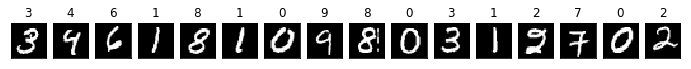

In [4]:
image_size = int(np.sqrt(X_train.shape[1]))
show_image_n = 16

fig = plt.figure(figsize=(12, 1))
for i in range(1, show_image_n + 1):
    ax = fig.add_subplot(1, show_image_n, i)
    
    ax.set_title(f'{y_train[i]}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.imshow(X_train[i].reshape(image_size, image_size), cmap="gray")

Define function that creates out model.

In [5]:
def model_fn(features, labels, mode):
    # input
    X = features['x']
    y = labels
    
    # layers
    result = tf.layers.dense(inputs=X, units=500, use_bias=False)
    result = tf.nn.relu(result)
    result = tf.layers.dense(inputs=X, units=10, use_bias=False)

    predictions = {
      'labels': tf.argmax(input=result, axis=1),
      'probs': tf.nn.softmax(result, name="softmax")
    }

    # predict
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # train
    loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=result)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss = loss,
            global_step = tf.train.get_global_step()
        )
        
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # test
    eval_metric_ops = {
      'accuracy': tf.metrics.accuracy(
          labels = y,
          predictions = predictions['labels']
      )
    }

    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

Create classifier.

In [6]:
classifier = tf.estimator.Estimator(
    model_fn = model_fn,
    model_dir="./mnist_model",
    config = tf.estimator.RunConfig(save_checkpoints_steps=100)
)

Train our model.

In [7]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': X_train},
    y = y_train,
    batch_size = 32,
    num_epochs = 5,
    shuffle = True
)

%time classifier.train(input_fn = train_input_fn)

CPU times: user 22.4 s, sys: 2.53 s, total: 24.9 s
Wall time: 17.1 s


In [ ]:
Test out model.

In [ ]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': X_test},
    y = y_test,
    num_epochs = 1,
    shuffle = False
)

%time print(classifier.evaluate(input_fn=eval_input_fn))

{'accuracy': 0.9232, 'loss': 0.27321193, 'global_step': 8594}
CPU times: user 492 ms, sys: 78.2 ms, total: 570 ms
Wall time: 474 ms


In [ ]:
image_size = int(np.sqrt(X_train.shape[1]))

show_h = 10
show_w = 6
show_n = show_h * show_w

result = list(classifier.predict(input_fn=eval_input_fn))


fig = plt.figure(figsize=(18, 18))
ticks = list(range(10))

for i in range(0, show_n):
    label = result[i]['labels']
    probs = result[i]['probs']
    
    ax = fig.add_subplot(show_h, 2 * show_w, 2 * i + 1)
    
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.imshow(X_train[i].reshape(image_size, image_size), cmap="gray")
    
    ax = fig.add_subplot(show_h, 2 * show_w, 2 * i + 2)
    
    ax.get_xaxis().set_visible(False)
    ax.set_xticks(ticks=ticks)
    
    ax.imshow(probs.reshape(-1, 1), cmap='gray')